In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 如果输入输出维度不匹配，使用1x1卷积进行维度调整
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = x
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = nn.ReLU()(out)
        return out

In [4]:
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            ResidualBlock(64, 64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            ResidualBlock(128, 128),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

In [5]:
datadir = "../data/CIFAR-10/"
metapath = "../data/CIFAR-10/batches.meta"
modelpath = "../model/task3/CIFAR-10.pth"

In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, num_classes):
    one_hot_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

In [7]:
meta = unpickle(metapath)
for key in meta.keys():
    print(f"{key}: {meta[key]}")

# 索引 -> 名称
idx2name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

b'num_cases_per_batch': 10000
b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
b'num_vis': 3072


In [8]:
data = []
labels = []

# 读取数据
for i in range(1, 6):
    batch_data = unpickle(f"{datadir}data_batch_{i}")
    data.append(batch_data[b'data'])
    labels.append(batch_data[b'labels'])

# 拼接数据
data = np.concatenate(data)
labels = np.concatenate(labels)

# 随机打乱数据
np.random.seed(0)
indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

data = data.reshape(-1, 3, 32, 32)      # 添加通道维度
one_hot_labels = one_hot(labels, 10)    # one-hot 编码

print(f"data shape: {data.shape}")
print(f"labels shape: {labels.shape}")
print(f"one-hot labels shape: {one_hot_labels.shape}")


data shape: (50000, 3, 32, 32)
labels shape: (50000,)
one-hot labels shape: (50000, 10)


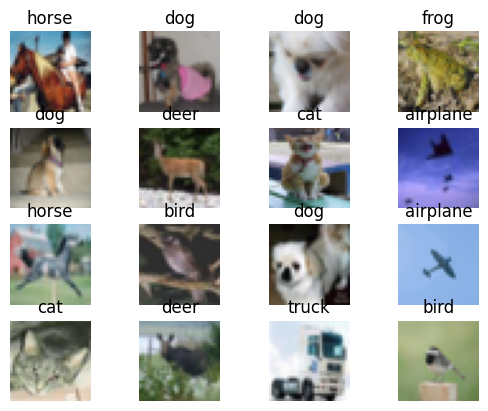

In [9]:
# 显示 CIFAR-10
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data[i].transpose(1, 2, 0))
    plt.title(idx2name[labels[i]])
    plt.axis('off')
plt.show()

In [10]:
# 划分训练集和验证集
split = int(len(data) * 0.8)
train_data, valid_data = data[:split], data[split:]
train_labels, valid_labels = one_hot_labels[:split], one_hot_labels[split:]

# 转换为 PyTorch 张量
train_data = torch.from_numpy(train_data).float()
valid_data = torch.from_numpy(valid_data).float()

train_labels = torch.from_numpy(train_labels).float()
valid_labels = torch.from_numpy(valid_labels).float()

train_dataset = TensorDataset(train_data, train_labels)
valid_dataset = TensorDataset(valid_data, valid_labels)

In [11]:
epochs = 200
best_accuracy = 0.0

batch_size = 64        # 批大小
initial_lr = 0.01       # 初始学习率
lr_patience = 5        # 学习率衰减耐心
lr_decay = 0.5          # 学习率衰减因子

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = CIFAR10().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay, patience=lr_patience)

In [13]:
pbar = tqdm(range(epochs), desc="Training")

for i in pbar:
    model.train()
    running_loss = 0.0
    test_loss = 0.0
    accuracy = 0.0
    for x, y in train_loader:
        # 加载进GPU
        x, y = x.to(device), y.to(device)
        # 清空梯度
        optimizer.zero_grad()
        # 前向传播
        outputs = model(x)
        # 计算损失
        loss = loss_func(outputs, torch.max(y, 1)[1])
        running_loss += loss.item()
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()

    # 在验证集上测试
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            # 加载进GPU
            x, y = x.to(device), y.to(device)
            # 预测
            pred = model(x)
            # 计算损失
            loss = loss_func(pred, y)
            test_loss += loss.item()
            # 计算准确率
            accuracy += torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).item()
    
    # 评估
    running_loss /= len(train_loader)
    test_loss /= len(valid_loader)
    accuracy /= len(valid_dataset)
    scheduler.step(test_loss)   # 更新学习率

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), modelpath)

    pbar.set_postfix(
        loss=running_loss,
        test_loss=test_loss,
        accuracy=f"{accuracy*100:.2f}%",
        best_accuracy=f"{best_accuracy*100:.2f}%",
        lr=optimizer.param_groups[0]['lr']
    )

Training: 100%|██████████| 200/200 [32:57<00:00,  9.89s/it, accuracy=86.92%, best_accuracy=87.11%, loss=0.000329, lr=1.91e-8, test_loss=1.03]


In [14]:
print("architecture:", model)
print("param", sum(p.numel() for p in model.parameters()))
print("savepath:", modelpath)
print("best_accuracy:", f"{best_accuracy*100:.2f}%")

architecture: CIFAR10(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [15]:
# For interview
interview_path = "../data/CIFAR-10/data_batch_5"

data = unpickle(interview_path)
interview_data = data[b'data']
interview_labels = data[b'labels']

interview_data = interview_data.reshape(-1, 3, 32, 32)
interview_data = torch.from_numpy(interview_data).float().to(device)

interview_labels = one_hot(interview_labels, 10)
interview_labels = torch.from_numpy(interview_labels).float().to(device)

In [16]:
# For interview
model.load_state_dict(torch.load(modelpath))

model.eval()
with torch.no_grad():
    pred = model(interview_data)
    pred_labels = torch.argmax(pred, dim=1)
    true_labels = torch.argmax(interview_labels, dim=1)
    accuracy = torch.sum(pred_labels == true_labels).item() / len(interview_data)
    print(f"interview accuracy: {accuracy * 100:.2f}%")

interview accuracy: 97.55%
